Please upload your ECG dataset (CSV with one column of ECG values).


Saving ECGCvdata.csv to ECGCvdata.csv
File uploaded: ECGCvdata.csv
Heart Rate: 36.0 bpm
Abnormal spikes detected: 0


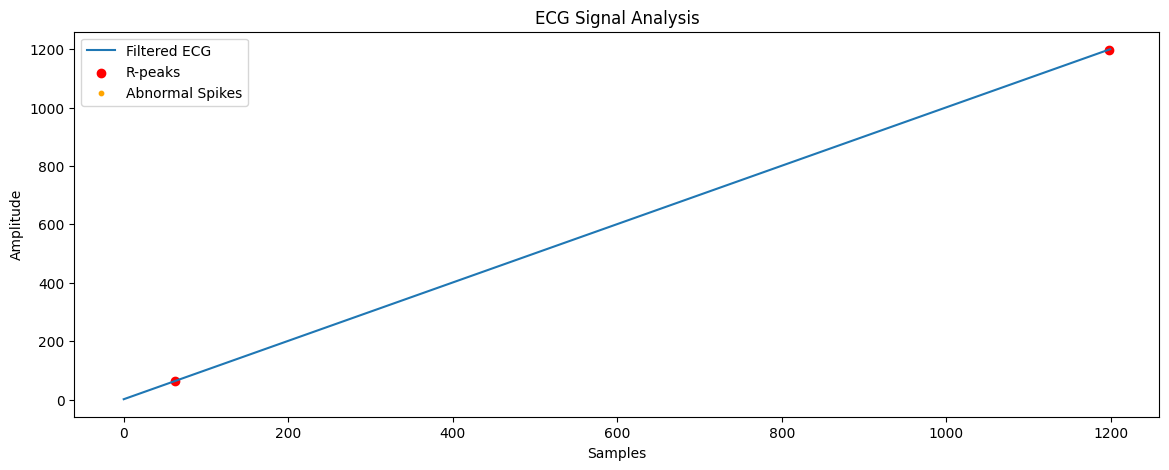

Sustained abnormal regions (start, end, duration in sec):


In [3]:
!pip install biosppy peakutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import biosppy.signals.ecg as ecg
from google.colab import files

# --------------------------
# 1️⃣ Upload dataset
# --------------------------
print("Please upload your ECG dataset (CSV with one column of ECG values).")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("File uploaded:", filename)

# --------------------------
# 2️⃣ Load ECG data
# --------------------------
data = pd.read_csv(filename)
ecg_signal = data.iloc[:,0].values
fs = 360  # Sampling frequency (update according to your dataset)

# --------------------------
# 3️⃣ Filter ECG
# --------------------------
def lowpass_filter(signal, cutoff=35, fs=fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, signal)

ecg_filtered = lowpass_filter(ecg_signal)

# --------------------------
# 4️⃣ Detect R-peaks
# --------------------------
rpeaks = ecg.engzee_segmenter(signal=ecg_filtered, sampling_rate=fs)[0]

# --------------------------
# 5️⃣ Calculate heart rate
# --------------------------
duration_sec = len(ecg_filtered)/fs
heart_rate = len(rpeaks) * 60 / duration_sec
print("Heart Rate:", heart_rate, "bpm")

# --------------------------
# 6️⃣ Detect abnormal spikes
# --------------------------
threshold = np.mean(ecg_filtered) + 2*np.std(ecg_filtered)
abnormal_peaks = np.where(ecg_filtered > threshold)[0]
print("Abnormal spikes detected:", len(abnormal_peaks))

# Identify sustained abnormal regions (>5 seconds)
sustained_regions = []
cluster_start = None
for i in range(len(abnormal_peaks)-1):
    if cluster_start is None:
        cluster_start = abnormal_peaks[i]
    if abnormal_peaks[i+1] - abnormal_peaks[i] > fs:  # gap > 1 second
        cluster_end = abnormal_peaks[i]
        duration = (cluster_end - cluster_start)/fs
        if duration >= 5:
            sustained_regions.append((cluster_start, cluster_end, duration))
        cluster_start = None

# --------------------------
# 7️⃣ Plot ECG
# --------------------------
plt.figure(figsize=(14,5))
plt.plot(ecg_filtered, label='Filtered ECG')
plt.scatter(rpeaks, ecg_filtered[rpeaks], c='red', label='R-peaks')
plt.scatter(abnormal_peaks, ecg_filtered[abnormal_peaks], c='orange', label='Abnormal Spikes', s=10)

# Highlight sustained abnormal regions
for start, end, dur in sustained_regions:
    plt.axvspan(start, end, color='purple', alpha=0.3, label='Sustained Abnormal')

plt.title("ECG Signal Analysis")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

print("Sustained abnormal regions (start, end, duration in sec):")
for region in sustained_regions:
    print(region)